In [1]:
import os
import time
import itertools

import numpy as np
import pandas as pd

import ipyvolume as ipv
from pathlib import Path

from tyssue import Sheet, config
from tyssue.io import hdf5
from tyssue.draw.ipv_draw import view_ipv
from tyssue.core.sheet import get_opposite
from tyssue.draw.plt_draw import quick_edge_draw
from tyssue.dynamics import effectors, units
from tyssue.solvers.sheet_vertex_solver import Solver


from invagination.ellipsoid import EllipsoidGeometry as geom
from invagination.ellipsoid import VitellineElasticity
from invagination.plots import (mesoderm_position,
                                panel_sagittal_view,
                               save_3_axis_plot,
                               save_ventral_plot)
from invagination.toolbox import (open_sheet,
                                  force_ratio,
                                  define_depth,
                                  define_time_max_depth,
                                  define_time_depth_compare_to_vivo,
                                 face_centered_patch)
from tyssue.draw.ipv_draw import sheet_view
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors
import matplotlib.cm as cmx

%matplotlib inline

SIM_DIR = Path('/home/admin-suz/Documents/Simulations/Surface_tension/2018-11-15')
#SIM_DIR = Path('/media/admin-suz/Sophie/2018/Papiers-EMT-Melanie/datas/')

old = None

In [10]:

dirname = SIM_DIR/'2018-09-07_TEST0'
#target_dirname = Path('/home/admin-suz/Documents/SimulationsReview/')/'2018-07-12'
list_dir = sorted(os.listdir(dirname))
#list_dir = list_dir[5:7:1] + list_dir[12:25:6]
#list_dir = list_dir[0:20:6]
list_dir

FileNotFoundError: [Errno 2] No such file or directory: '/home/admin-suz/Documents/short_simulation/file_to_copy/2018-09-07_TEST0'

/home/admin-suz/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


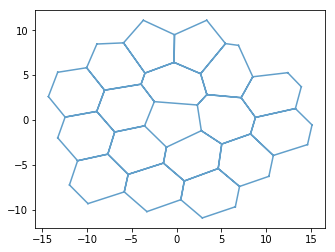

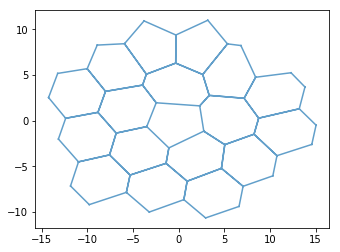

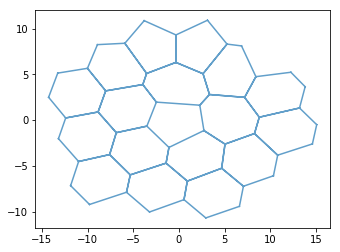

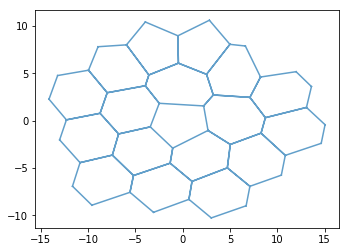

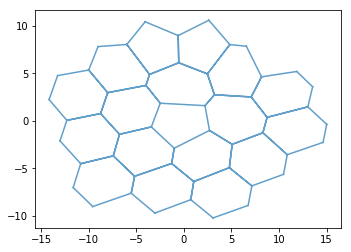

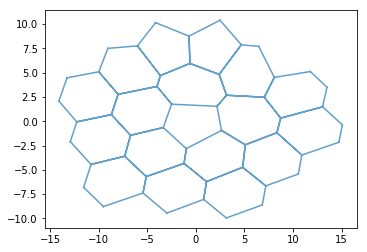

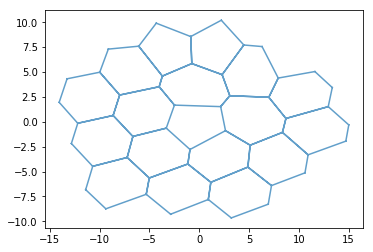

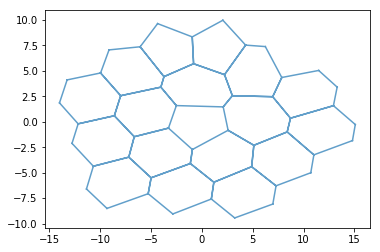

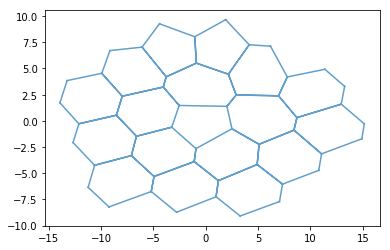

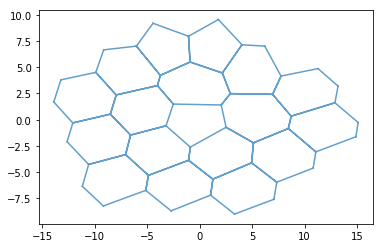

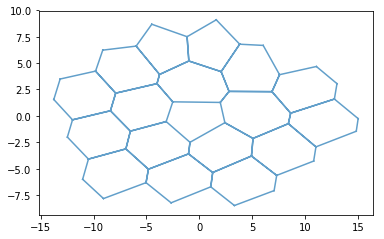

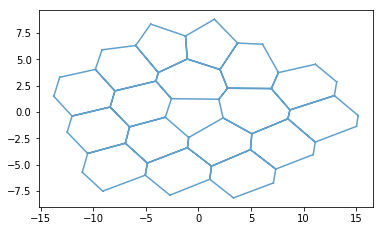

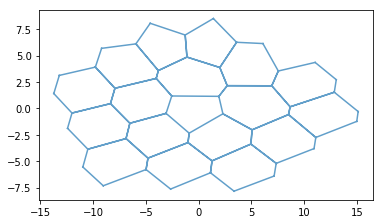

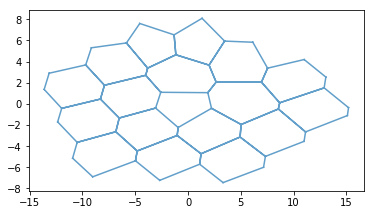

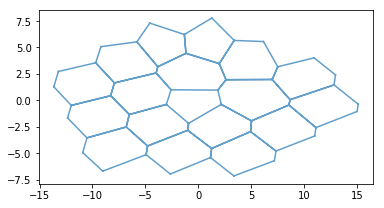

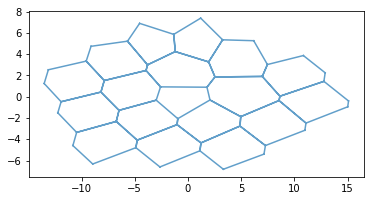

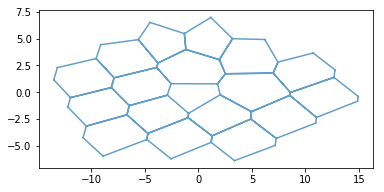

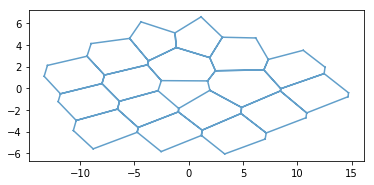

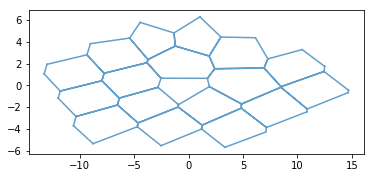

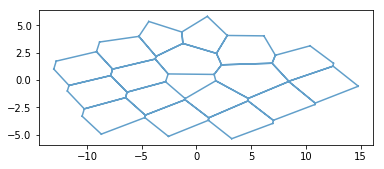

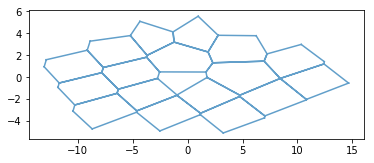

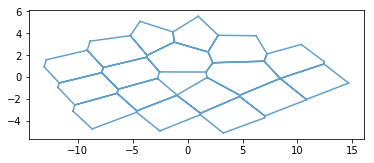

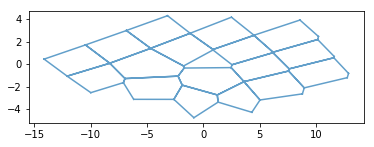

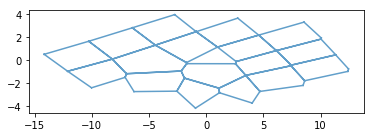

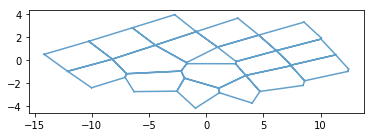

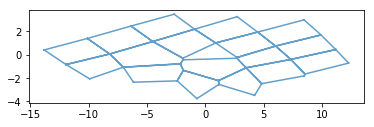

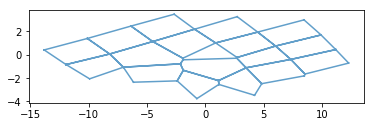

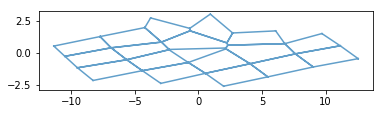

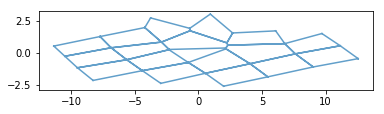

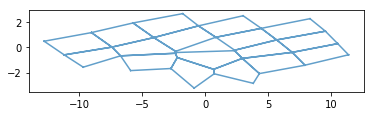

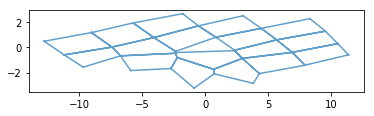

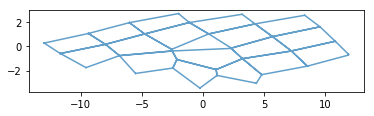

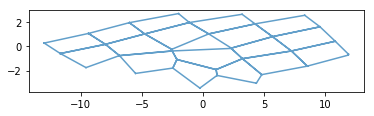

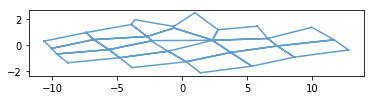

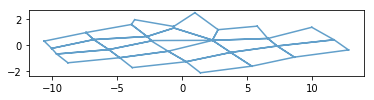

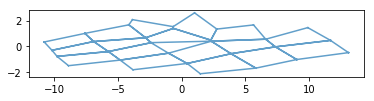

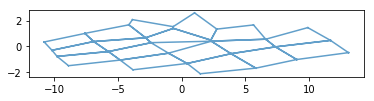

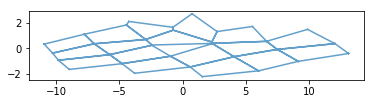

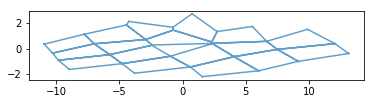

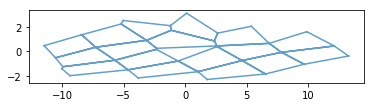

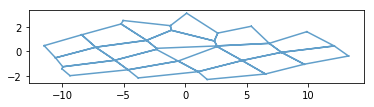

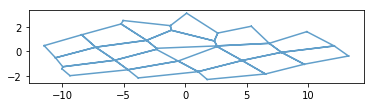

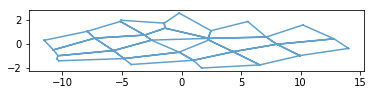

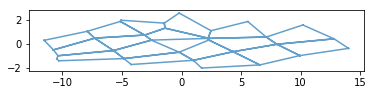

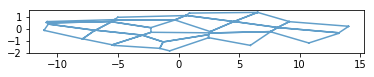

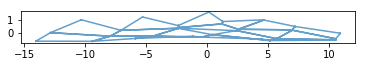

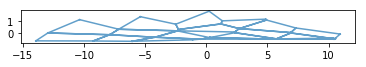

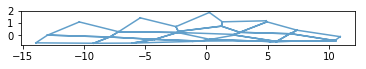

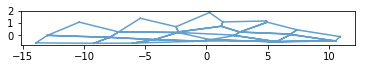

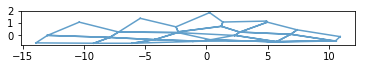

In [166]:
for t in range(0,50):
    sheet = open_sheet(os.path.join(dirname, list_dir[1]),t)
    patch = face_centered_patch(sheet, 53, 2)
    fig, ax = quick_edge_draw(patch, ['x', 'y'],
                              alpha=0.7)

/home/admin-suz/Documents/Simulations/Surface_tension/2018-11-15/1.08_contractility_5_critical_area_30_radialtension


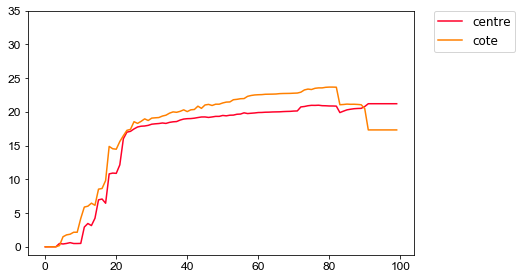

In [6]:
dirname = SIM_DIR/'1.08_contractility_5_critical_area_30_radialtension/'
fig, ax1 = plt.subplots()
color_list = [(0.0, 0.5, 1.0, 1.0), 
              (0.16304347826086973, 0.0, 1.0, 1.0),
              (1.0, 0.5, 0.0, 1.0),
              (1.0, 0.0, 0.16, 1.0)
            ]

color_list = [(1.0, 0.0, 0.16, 1.0),
            (1.0, 0.5, 0.0, 1.0), 
            (0.0, 0.5, 0.0, 1.0), 
            (0.0, 0.5, 1.0, 1.0), 
            (0.16304347826086973, 0.0, 1.0, 1.0), 
            (0.51, 0.0, 0.51, 1.0)]
i=0
list_dir = [dirname]
for d in list_dir:
    print (d)
    depth_0 = define_depth(os.path.join(dirname, d), 0, ['z', 'x'])
    depth=[]
    for t in range(0, 100):
        depth.append(depth_0 - define_depth(os.path.join(dirname, d),t, ['z', 'x']))
    ax1.plot(depth,color=color_list[i],label = 'centre')
    i=i+1
    depth_0 = define_depth(os.path.join(dirname, d), 0, ['z', 'x'], xmin=-90, xmax=-50)
    depth=[]
    for t in range(0, 100):
        depth.append(depth_0 - define_depth(os.path.join(dirname, d),t, ['z', 'x'], xmin=-90, xmax=-50))
    ax1.plot(depth,color=color_list[i],label = 'cote')
    i=i+1
    
    
ax1.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., prop={'size': 12, 'family':'sans-serif'})


#ax1.set_xlabel('time step', size=12, family='sans-serif', fontname='Arial')
#ax1.set_ylabel('depth', size=12, family='sans-serif', fontname = 'Arial')
for tick in ax1.xaxis.get_ticklabels():
    tick.set_fontsize(12)
    tick.set_fontname('Arial')
for tick in ax1.yaxis.get_ticklabels():
    tick.set_fontsize(12)
    tick.set_fontname('Arial')
ax1.set_ylim(ymax=35)
fig.set_size_inches(6, 4)
fig.savefig('../depth_time.svg', dpi = 150)


fig.tight_layout()
plt.show()


In [7]:
# nombre de cellule qui tirent au cours du temps :
list_nb_pulling_cell = []

chosen_dir = list_dir[0]
print(chosen_dir)

sheet = open_sheet(os.path.join(dirname, chosen_dir),0)
depth_0 = define_depth(os.path.join(dirname, chosen_dir), 0, ['z', 'x'])
depth=[]
for t in range(0,100):
    sheet = open_sheet(os.path.join(dirname, chosen_dir),t)
    depth.append(depth_0 - define_depth(os.path.join(dirname, chosen_dir),t, ['z', 'x']))
    sheet.vert_df[sheet.vert_df.radial_tension>0]
    res=(sheet.edge_df[(sheet.edge_df.srce.isin(sheet.vert_df[sheet.vert_df.radial_tension>0].index))
                           &
                           (sheet.edge_df.trgt.isin(sheet.vert_df[sheet.vert_df.radial_tension>0].index))])
    for f in res.face.unique() : 
        if len(res[res.face==f]) == 1:
            res= res.drop(res[res.face==f].index)
    list_nb_pulling_cell.append(len(res.face.unique()))

/home/admin-suz/Documents/Simulations/Surface_tension/2018-11-15/1.08_contractility_5_critical_area_30_radialtension


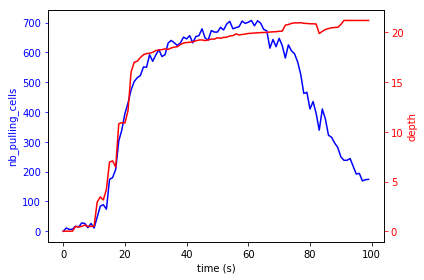

In [8]:
fig, ax1 = plt.subplots()
ax1.plot( list_nb_pulling_cell, 'b-')
ax1.set_xlabel('time (s)')
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('nb_pulling_cells', color='b')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
ax2.plot(depth, 'r-')
ax2.set_ylabel('depth', color='r')
ax2.tick_params('y', colors='r')

fig.tight_layout()
plt.show()


### Save ventral plots

In [113]:

for plot_dir in list_dir[13:21:2] : 
    print (plot_dir)
    save_ventral_plot(os.path.join(dirname, plot_dir), 
                  start=0, step=5, max_area=40,face_caracteristic='area',
                  face_color='Blues', edge_color='hot', 
                  edge_normalization=4)


1.08_contractility_5_critical_area_10_radialtension
1.08_contractility_5_critical_area_25_radialtension
1.08_contractility_5_critical_area_30_radialtension
1.08_contractility_5_critical_area_50_radialtension


In [12]:
for dir_ in list_dir:
    print (dir_)
    save_3_axis_plot(os.path.join(dirname, dir_),
                     1, 40, 'png')

1.08_contractility_5_critical_area_30_radialtension


KeyboardInterrupt: 

### Plot maximal depth according to force

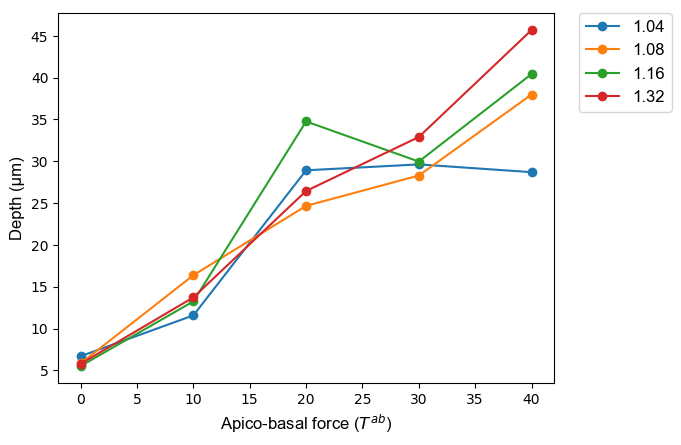

In [232]:
mpl.rcParams.update(mpl.rcParamsDefault)
contractility = ['1.04','1.08', '1.16', '1.32']
force = ['0', '10', '20', '30', '40']

from invagination.toolbox import define_depth
def define_time_max_depth(directory, nb_t=200):
    """Define time and depth where the depths
    is maximal in a directory
    """
    depth_0 = define_depth(directory, 0, ['z', 'x'])

    depths = []
    for t in range(0, nb_t):
        try : 
            depths.append(depth_0 - define_depth(directory, t, ['z', 'x']))
        except Exception:
            depths.append(0)

    time = depths.index(max(depths))
    return time, max(depths)

fig, ax = plt.subplots()

for c in contractility : 
    stores = [f for f in list_dir if not(f.find(c))] 
    list_t = {}
    for fab in force : 
        file_directory = [f for f in stores if (f.find(str('_'+fab+'_')))>0] [0]
        
        t,d =  define_time_max_depth(os.path.join(dirname, file_directory))
        list_t[fab] = d
        
        #list_t[fab] = result_dataframe.loc[file_directory,'depth']
    
    
    ax.plot ([int (u)for u in list_t.keys()], [float (u)for u in list_t.values()], 
             '.-',markersize=12, label = round(float(c), 2))


ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., prop={'size': 12, 'family':'Arial'})
ax.set_xlabel('Apico-basal force ($T^{ab}$)', size=12, family='Arial')
ax.set_ylabel('Depth (µm)', size=12, family='Arial')
fig.savefig('../depth_contractility.svg', dpi = 300)

In [32]:
from invagination.plots import (sagittal_view)

def panel_sagittal_view2(directory, df, ax=None):

    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = ax.get_figure()

    t, d = define_time_max_depth(directory, 200)
    df.loc[str(directory).split('/')[-1], 'time'] = t
    df.loc[str(directory).split('/')[-1], 'depth'] = d

    # Calcul du rapport de force
    sheet = open_sheet(directory, t)
    r = force_ratio(sheet)
    df.loc[str(directory).split('/')[-1], 'Fab/Fc'] = r
    print(directory)
    print(df.loc[str(directory).split('/')[-1]])

    # sagital view
    fig, ax = sagittal_view(
        sheet, -5, 5, 'is_mesoderm', ['x', 'y'], 'z', ax)
    a, c = 87, 87
    thetas = np.linspace(0, 2 * np.pi)
    ax.plot(c * np.cos(thetas), a * np.sin(thetas), color='grey', alpha=0.7)
    ax.set_xlim(-100, 100)
    ax.set_ylim(-100, 100)

    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.text(1, 2, round(r, 3), horizontalalignment='center',
            verticalalignment='center')

## Plot pannel for principal figure

/home/admin-suz/Documents/SimulationsReview/2018-08-01/1.32_contractility_5_critical_area_0_radialtension
time          186
depth     5.78085
Fab/Fc          0
Name: 1.32_contractility_5_critical_area_0_radialtension, dtype: object
/home/admin-suz/Documents/SimulationsReview/2018-08-01/1.32_contractility_5_critical_area_10_radialtension
time              86
depth        13.7251
Fab/Fc    0.00100195
Name: 1.32_contractility_5_critical_area_10_radialtension, dtype: object
/home/admin-suz/Documents/SimulationsReview/2018-08-01/1.32_contractility_5_critical_area_20_radialtension
time             57
depth       26.4517
Fab/Fc    0.0556026
Name: 1.32_contractility_5_critical_area_20_radialtension, dtype: object
/home/admin-suz/Documents/SimulationsReview/2018-08-01/1.32_contractility_5_critical_area_30_radialtension
time            40
depth      32.9068
Fab/Fc    0.170805
Name: 1.32_contractility_5_critical_area_30_radialtension, dtype: object
/home/admin-suz/Documents/SimulationsReview/2018

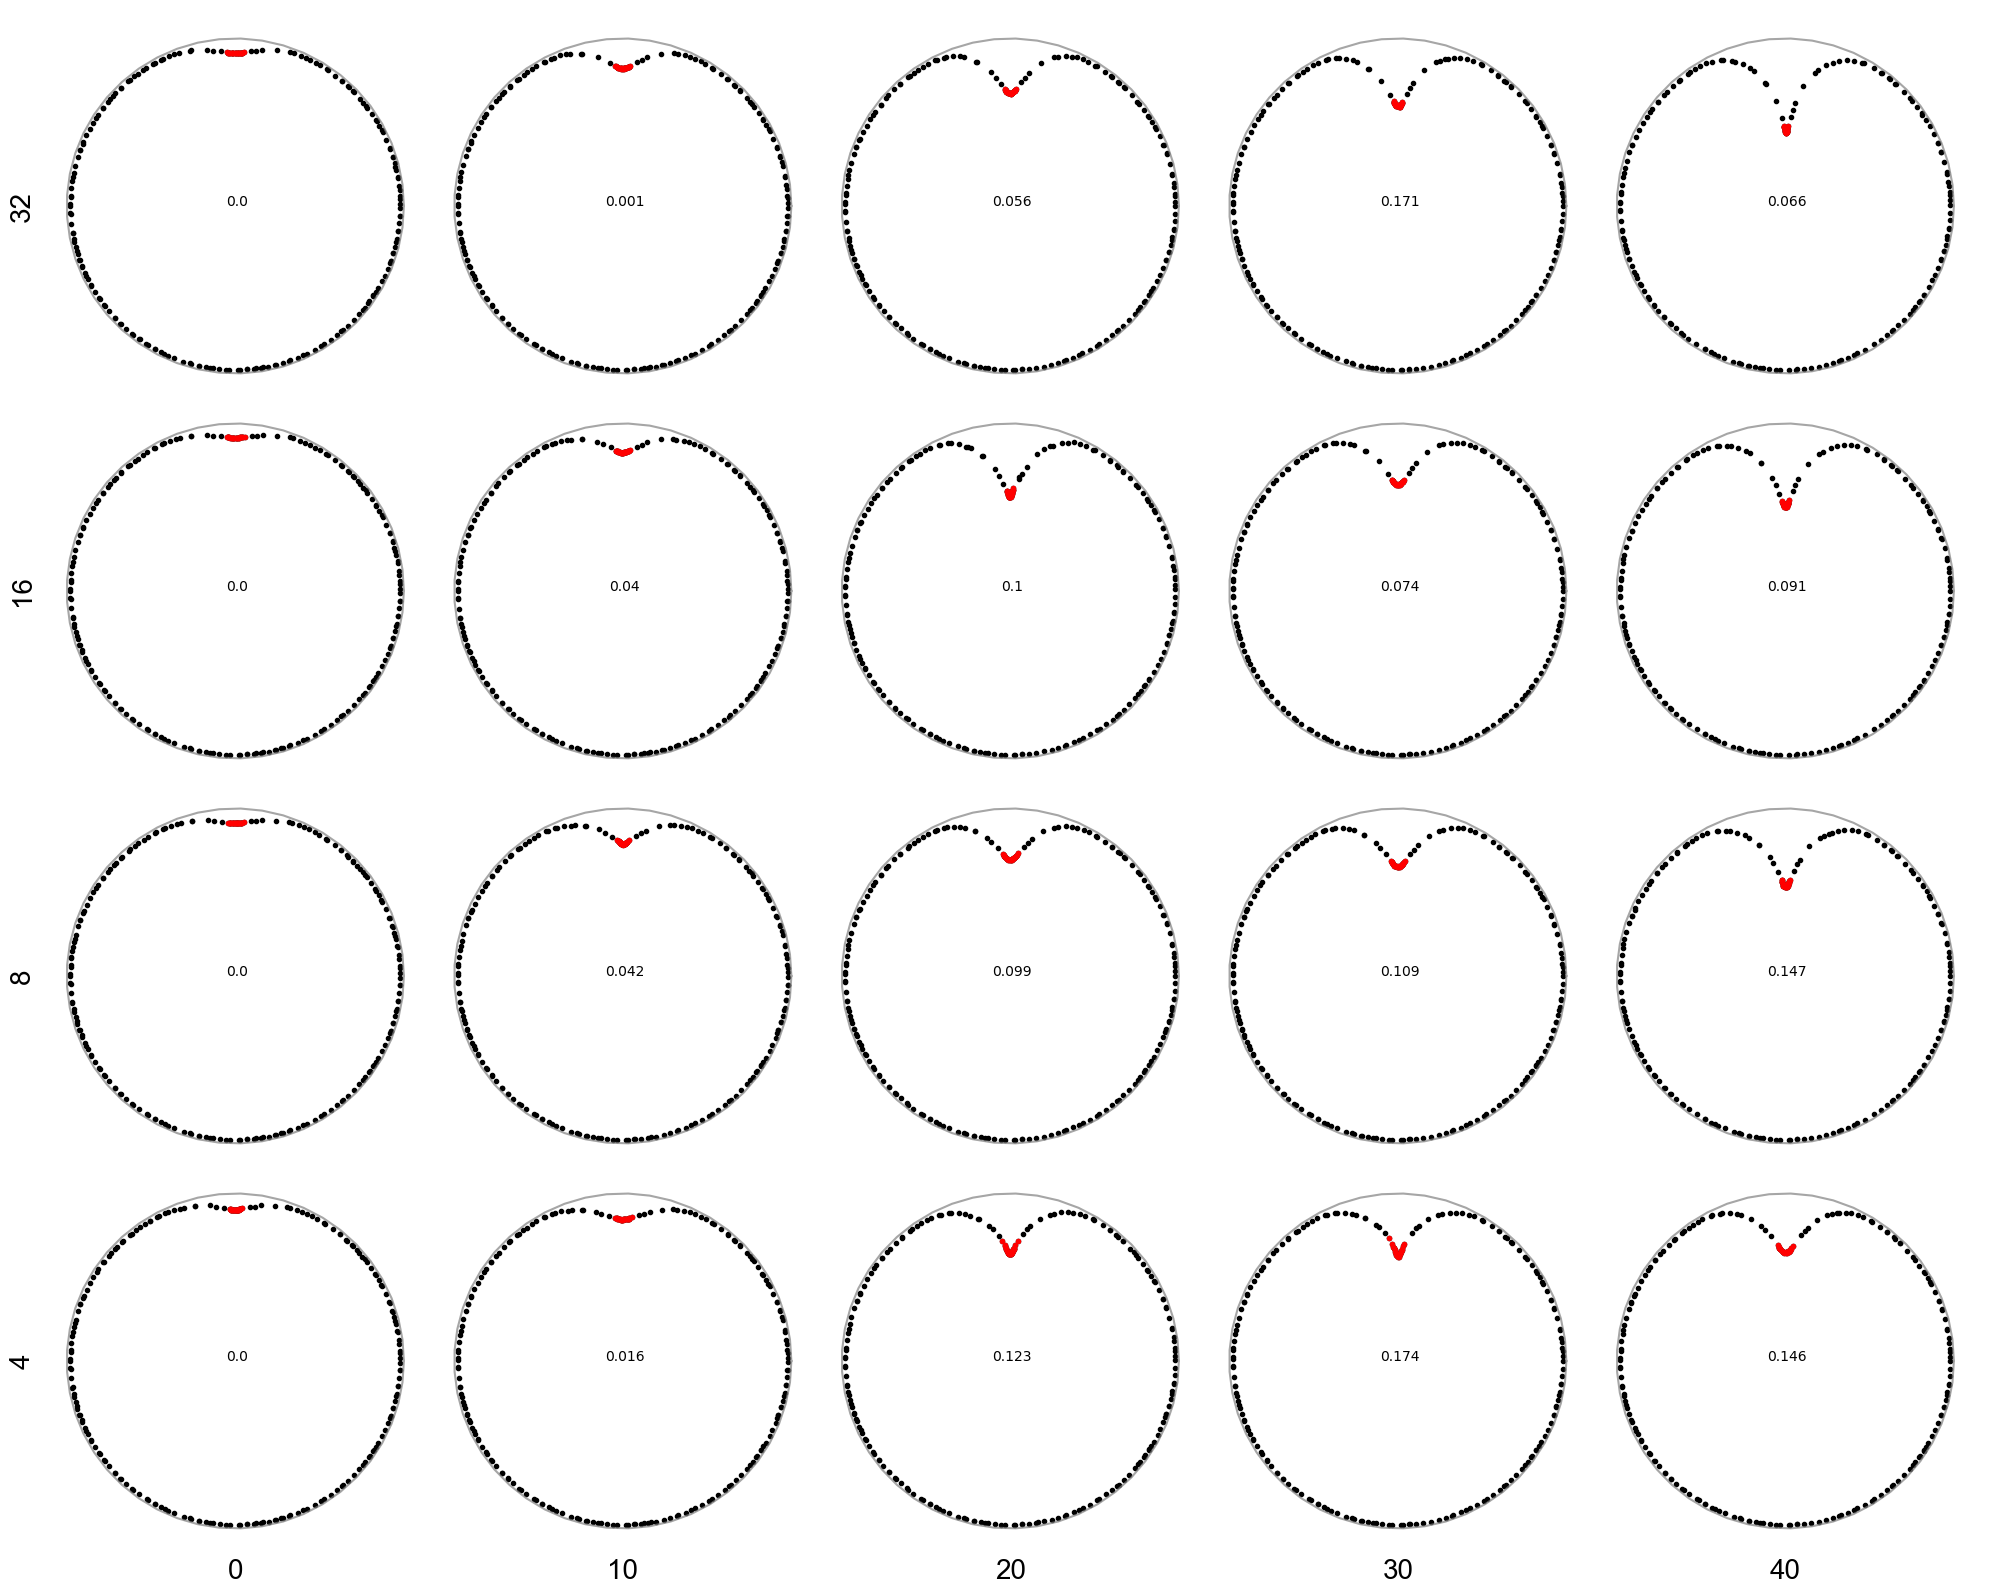

In [234]:
import matplotlib
matplotlib.rc('axes', edgecolor='white')

result_dataframe = pd.DataFrame(index = list_dir, columns = ('time', 'depth', 'Fab/Fc'))
"""fig = plt.figure(figsize=(25, 5))
grid = gridspec.GridSpec(1, 5, wspace=0.0, hspace=0.0)

axes_1_1 = fig.add_subplot(grid[0, 0])
axes_1_2 = fig.add_subplot(grid[0, 1])
axes_1_3 = fig.add_subplot(grid[0, 2])
axes_1_4 = fig.add_subplot(grid[0, 3])
axes_1_5 = fig.add_subplot(grid[0, 4])"""


fig = plt.figure(figsize=(25, 20))
grid = gridspec.GridSpec(4, 5, wspace=0.0, hspace=0.0)


axes_2_1 = fig.add_subplot(grid[0, 0])
axes_2_2 = fig.add_subplot(grid[0, 1])
axes_2_3 = fig.add_subplot(grid[0, 2])
axes_2_4 = fig.add_subplot(grid[0, 3])
axes_2_5 = fig.add_subplot(grid[0, 4])

axes_3_1 = fig.add_subplot(grid[1, 0])
axes_3_2 = fig.add_subplot(grid[1, 1])
axes_3_3 = fig.add_subplot(grid[1, 2])
axes_3_4 = fig.add_subplot(grid[1, 3])
axes_3_5 = fig.add_subplot(grid[1, 4])

axes_4_1 = fig.add_subplot(grid[2, 0])
axes_4_2 = fig.add_subplot(grid[2, 1])
axes_4_3 = fig.add_subplot(grid[2, 2])
axes_4_4 = fig.add_subplot(grid[2, 3])
axes_4_5 = fig.add_subplot(grid[2, 4])

axes_5_1 = fig.add_subplot(grid[3, 0])
axes_5_2 = fig.add_subplot(grid[3, 1])
axes_5_3 = fig.add_subplot(grid[3, 2])
axes_5_4 = fig.add_subplot(grid[3, 3])
axes_5_5 = fig.add_subplot(grid[3, 4])



panel_sagittal_view(dirname/'1.32_contractility_5_critical_area_0_radialtension/', result_dataframe, axes_2_1)
panel_sagittal_view(dirname/'1.32_contractility_5_critical_area_10_radialtension/', result_dataframe, axes_2_2)
panel_sagittal_view(dirname/'1.32_contractility_5_critical_area_20_radialtension/', result_dataframe, axes_2_3)
panel_sagittal_view(dirname/'1.32_contractility_5_critical_area_30_radialtension/', result_dataframe, axes_2_4)
panel_sagittal_view(dirname/'1.32_contractility_5_critical_area_40_radialtension/', result_dataframe,axes_2_5)

panel_sagittal_view(dirname/'1.16_contractility_5_critical_area_0_radialtension/', result_dataframe, axes_3_1)
panel_sagittal_view(dirname/'1.16_contractility_5_critical_area_10_radialtension/', result_dataframe, axes_3_2)
panel_sagittal_view(dirname/'1.16_contractility_5_critical_area_20_radialtension/', result_dataframe, axes_3_3)
panel_sagittal_view(dirname/'1.16_contractility_5_critical_area_30_radialtension/', result_dataframe, axes_3_4)
panel_sagittal_view(dirname/'1.16_contractility_5_critical_area_40_radialtension/', result_dataframe, axes_3_5)

panel_sagittal_view(dirname/'1.08_contractility_5_critical_area_0_radialtension/', result_dataframe, axes_4_1)
panel_sagittal_view(dirname/'1.08_contractility_5_critical_area_10_radialtension/', result_dataframe, axes_4_2)
panel_sagittal_view(dirname/'1.08_contractility_5_critical_area_20_radialtension/', result_dataframe, axes_4_3)
panel_sagittal_view(dirname/'1.08_contractility_5_critical_area_30_radialtension/', result_dataframe, axes_4_4)
panel_sagittal_view(dirname/'1.08_contractility_5_critical_area_40_radialtension/', result_dataframe, axes_4_5)

panel_sagittal_view(dirname/'1.04_contractility_5_critical_area_0_radialtension/', result_dataframe, axes_5_1)
panel_sagittal_view(dirname/'1.04_contractility_5_critical_area_10_radialtension/', result_dataframe, axes_5_2)
panel_sagittal_view(dirname/'1.04_contractility_5_critical_area_20_radialtension/', result_dataframe, axes_5_3)
panel_sagittal_view(dirname/'1.04_contractility_5_critical_area_30_radialtension/', result_dataframe, axes_5_4)
panel_sagittal_view(dirname/'1.04_contractility_5_critical_area_40_radialtension/', result_dataframe, axes_5_5)


axes_2_1.set_ylabel('32', size=20, family='Arial')
axes_3_1.set_ylabel('16', size=20, family='Arial')
axes_4_1.set_ylabel('8', size=20, family='Arial')
axes_5_1.set_ylabel('4', size=20, family='Arial')

axes_5_1.set_xlabel('0', size=20, family='Arial')
axes_5_2.set_xlabel('10', size=20, family='Arial')
axes_5_3.set_xlabel('20', size=20, family='Arial')
axes_5_4.set_xlabel('30', size=20, family='Arial')
axes_5_5.set_xlabel('40', size=20, family='Arial')


#plt.savefig('../paper/contract_force.svg', dpi = 300)
#result_dataframe.to_csv('result_principal_result.csv')
plt.savefig('../contract_force.svg', dpi = 300)

/home/admin-suz/Documents/short_simulation/file_to_copy/2018-09-09_TEST4


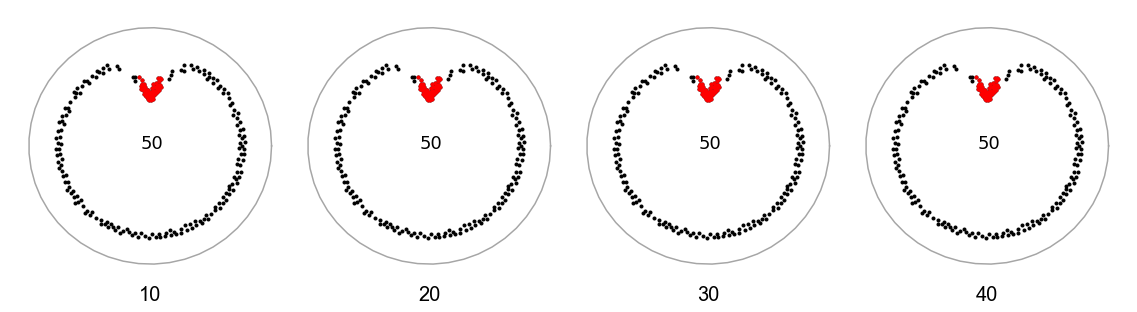

In [24]:
import matplotlib
matplotlib.rc('axes', edgecolor='white')
dirname = SIM_DIR/'2018-09-09_TEST4'
result_dataframe = pd.DataFrame(index = list_dir, columns = ('time', 'depth', 'Fab/Fc'))
"""fig = plt.figure(figsize=(25, 5))
grid = gridspec.GridSpec(1, 5, wspace=0.0, hspace=0.0)

axes_1_1 = fig.add_subplot(grid[0, 0])
axes_1_2 = fig.add_subplot(grid[0, 1])
axes_1_3 = fig.add_subplot(grid[0, 2])
axes_1_4 = fig.add_subplot(grid[0, 3])
axes_1_5 = fig.add_subplot(grid[0, 4])"""

print (dirname)
fig = plt.figure(figsize=(20, 5))
grid = gridspec.GridSpec(1, 4, wspace=0.0, hspace=0.0)


axes_2_1 = fig.add_subplot(grid[0, 3])
axes_3_1 = fig.add_subplot(grid[0, 2])
axes_4_1 = fig.add_subplot(grid[0, 1])
axes_5_1 = fig.add_subplot(grid[0, 0])


from invagination.plots import sagittal_view
def panel_sagittal_view(directory, df, t, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = ax.get_figure()

    sheet = open_sheet(directory, t)

    # sagital view
    z = 1
    if z == 1:
        fig, ax = sagittal_view(
            sheet, -100, -90, 'is_mesoderm', ['x', 'y'], 'z', ax)
    else : 
        fig, ax = sagittal_view(
            sheet, -5, 5, 'is_mesoderm', ['x', 'y'], 'z', ax)
    a, c = 87, 87
    thetas = np.linspace(0, 2 * np.pi)
    ax.plot(c * np.cos(thetas), a * np.sin(thetas), color='grey', alpha=0.7)
    ax.set_xlim(-100, 100)
    ax.set_ylim(-100, 100)
    
    ax.text(1, 2, t, horizontalalignment = 'center', verticalalignment = 'center', fontsize=18)

    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_yticks([]) 
    ax.set_xticks([]) 
    ax.set_xticklabels([])
    ax.set_yticklabels([])

panel_sagittal_view(dirname/'1.08_contractility_5_critical_area_30_radialtension_0/', result_dataframe, 50,axes_2_1)
panel_sagittal_view(dirname/'1.08_contractility_5_critical_area_30_radialtension_0/', result_dataframe, 50, axes_3_1)
panel_sagittal_view(dirname/'1.08_contractility_5_critical_area_30_radialtension_0/', result_dataframe, 50,axes_4_1)
panel_sagittal_view(dirname/'1.08_contractility_5_critical_area_30_radialtension_0/', result_dataframe, 50,axes_5_1)


axes_2_1.set_xlabel('40', size=20, family='Arial')
axes_3_1.set_xlabel('30', size=20, family='Arial')
axes_4_1.set_xlabel('20', size=20, family='Arial')
axes_5_1.set_xlabel('10', size=20, family='Arial')



#plt.savefig('../paper/contract_force.svg', dpi = 300)
#result_dataframe.to_csv('result_principal_result.csv')
plt.savefig('../contract_force.svg', dpi = 300)

#### Film from principal fig

FileNotFoundError: file /home/admin-suz/Documents/SimulationsReview/2018-08-01/1.32_contractility_5_critical_area_0_radialtension/invagination_0000.hf5 not found

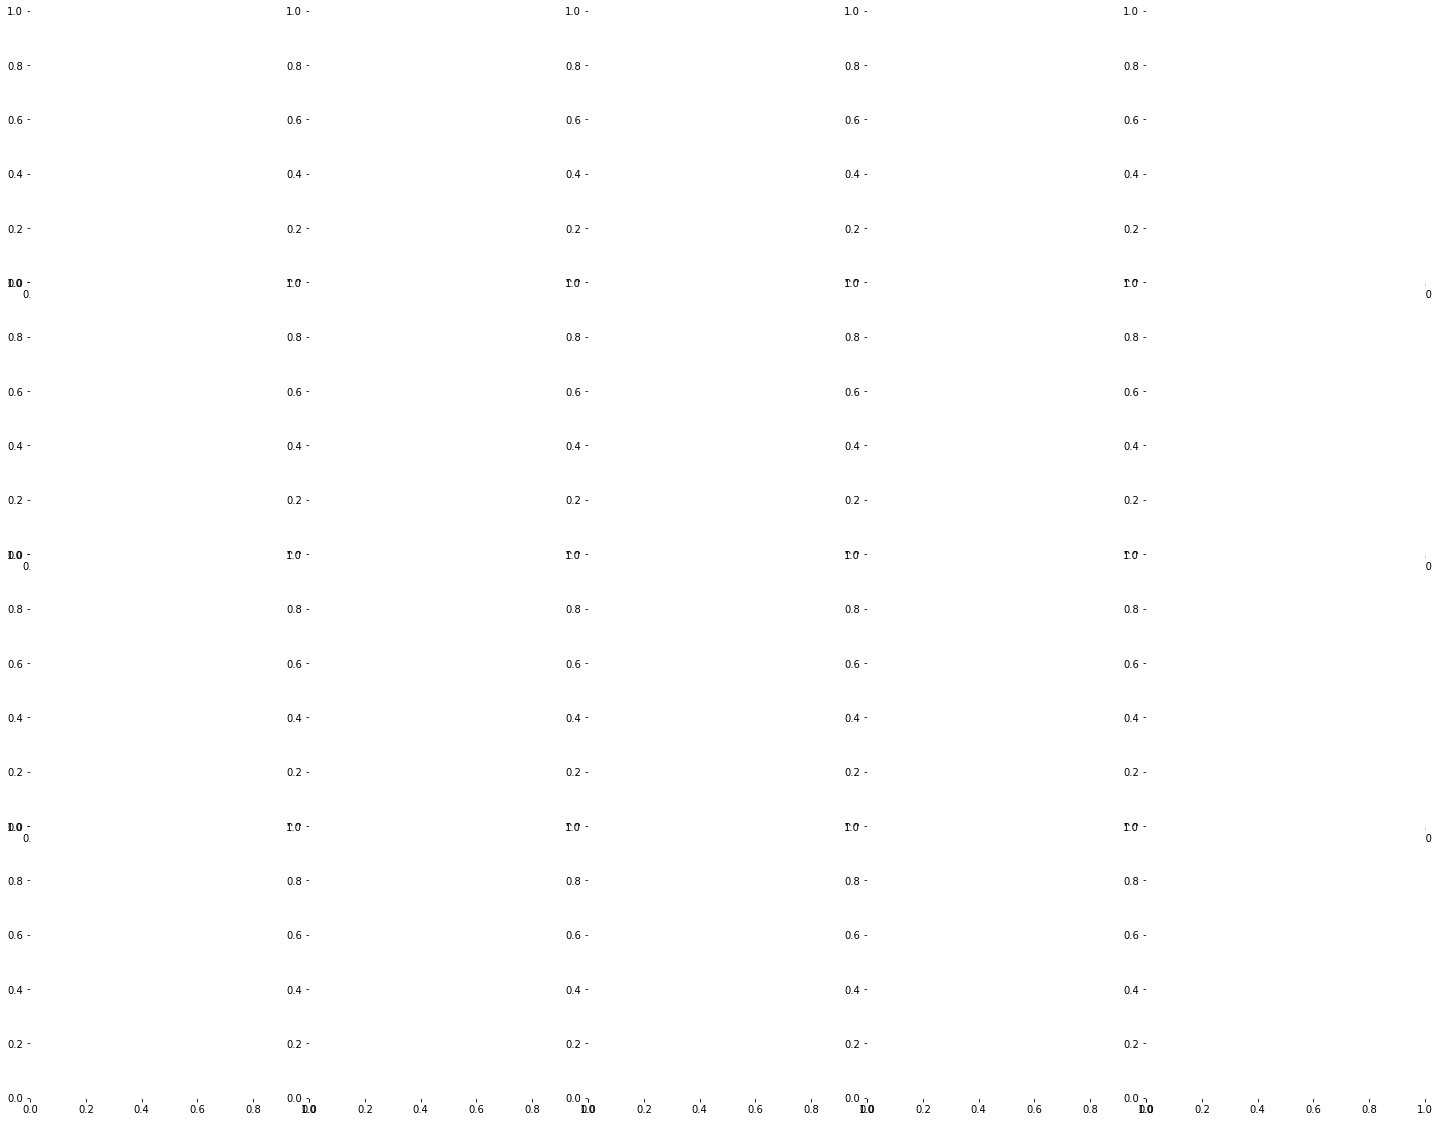

In [6]:
from invagination.plots import sagittal_view
def panel_sagittal_view(directory, df, t, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = ax.get_figure()

        
    list_t = {'1.32_contractility_5_critical_area_0_radialtension':186,
             '1.32_contractility_5_critical_area_10_radialtension':86,
             '1.32_contractility_5_critical_area_20_radialtension':57,
             '1.32_contractility_5_critical_area_30_radialtension':40,
             '1.32_contractility_5_critical_area_40_radialtension':60,
              
             '1.16_contractility_5_critical_area_0_radialtension':186,
             '1.16_contractility_5_critical_area_10_radialtension':58,
             '1.16_contractility_5_critical_area_20_radialtension':55,
             '1.16_contractility_5_critical_area_30_radialtension':69,
             '1.16_contractility_5_critical_area_40_radialtension':68,
             
             '1.08_contractility_5_critical_area_0_radialtension':199,
             '1.08_contractility_5_critical_area_10_radialtension':73,
             '1.08_contractility_5_critical_area_20_radialtension':68,
             '1.08_contractility_5_critical_area_30_radialtension':74,
             '1.08_contractility_5_critical_area_40_radialtension':74,
             
             '1.04_contractility_5_critical_area_0_radialtension':199,
             '1.04_contractility_5_critical_area_10_radialtension':115,
             '1.04_contractility_5_critical_area_20_radialtension':80,
             '1.04_contractility_5_critical_area_30_radialtension':71,
             '1.04_contractility_5_critical_area_40_radialtension':92,
             
             }
        
    """if t > list_t[str(directory).split('/')[-1]] :
        t = list_t[str(directory).split('/')[-1]] """
    sheet = open_sheet(directory, t)

    # sagital view
    fig, ax = sagittal_view(
        sheet, -80, -60, 'is_mesoderm', ['x', 'y'], 'z', ax)
    a, c = 87, 87
    thetas = np.linspace(0, 2 * np.pi)
    ax.plot(c * np.cos(thetas), a * np.sin(thetas), color='grey', alpha=0.7)
    ax.set_xlim(-100, 100)
    ax.set_ylim(-100, 100)
    
    ax.text(1, 2, t, horizontalalignment = 'center', verticalalignment = 'center', fontsize=18)

    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_yticks([]) 
    ax.set_xticks([]) 
    ax.set_xticklabels([])
    ax.set_yticklabels([])
       

        
import matplotlib
matplotlib.rc('axes', edgecolor='white')

result_dataframe = pd.DataFrame(index = list_dir, columns = ('time', 'depth', 'Fab/Fc'))
for t in range (0,200):
    fig = plt.figure(figsize=(25, 20))
    grid = gridspec.GridSpec(4, 5, wspace=0.0, hspace=0.0)


    axes_2_1 = fig.add_subplot(grid[0, 0])
    axes_2_2 = fig.add_subplot(grid[0, 1])
    axes_2_3 = fig.add_subplot(grid[0, 2])
    axes_2_4 = fig.add_subplot(grid[0, 3])
    axes_2_5 = fig.add_subplot(grid[0, 4])

    axes_3_1 = fig.add_subplot(grid[1, 0])
    axes_3_2 = fig.add_subplot(grid[1, 1])
    axes_3_3 = fig.add_subplot(grid[1, 2])
    axes_3_4 = fig.add_subplot(grid[1, 3])
    axes_3_5 = fig.add_subplot(grid[1, 4])

    axes_4_1 = fig.add_subplot(grid[2, 0])
    axes_4_2 = fig.add_subplot(grid[2, 1])
    axes_4_3 = fig.add_subplot(grid[2, 2])
    axes_4_4 = fig.add_subplot(grid[2, 3])
    axes_4_5 = fig.add_subplot(grid[2, 4])

    axes_5_1 = fig.add_subplot(grid[3, 0])
    axes_5_2 = fig.add_subplot(grid[3, 1])
    axes_5_3 = fig.add_subplot(grid[3, 2])
    axes_5_4 = fig.add_subplot(grid[3, 3])
    axes_5_5 = fig.add_subplot(grid[3, 4])

    dirname = SIM_DIR/'2018-08-01'

    panel_sagittal_view(dirname/'1.32_contractility_5_critical_area_0_radialtension/', result_dataframe, t, axes_2_1)
    panel_sagittal_view(dirname/'1.32_contractility_5_critical_area_10_radialtension/', result_dataframe, t, axes_2_2)
    panel_sagittal_view(dirname/'1.32_contractility_5_critical_area_20_radialtension/', result_dataframe, t, axes_2_3)
    panel_sagittal_view(dirname/'1.32_contractility_5_critical_area_30_radialtension/', result_dataframe, t, axes_2_4)
    panel_sagittal_view(dirname/'1.32_contractility_5_critical_area_40_radialtension/', result_dataframe, t, axes_2_5)

    panel_sagittal_view(dirname/'1.16_contractility_5_critical_area_0_radialtension/', result_dataframe, t, axes_3_1)
    panel_sagittal_view(dirname/'1.16_contractility_5_critical_area_10_radialtension/', result_dataframe, t, axes_3_2)
    panel_sagittal_view(dirname/'1.16_contractility_5_critical_area_20_radialtension/', result_dataframe, t, axes_3_3)
    panel_sagittal_view(dirname/'1.16_contractility_5_critical_area_30_radialtension/', result_dataframe, t, axes_3_4)
    panel_sagittal_view(dirname/'1.16_contractility_5_critical_area_40_radialtension/', result_dataframe, t, axes_3_5)

    panel_sagittal_view(dirname/'1.08_contractility_5_critical_area_0_radialtension/', result_dataframe, t, axes_4_1)
    panel_sagittal_view(dirname/'1.08_contractility_5_critical_area_10_radialtension/', result_dataframe, t, axes_4_2)
    panel_sagittal_view(dirname/'1.08_contractility_5_critical_area_20_radialtension/', result_dataframe, t, axes_4_3)
    panel_sagittal_view(dirname/'1.08_contractility_5_critical_area_30_radialtension/', result_dataframe, t, axes_4_4)
    panel_sagittal_view(dirname/'1.08_contractility_5_critical_area_40_radialtension/', result_dataframe, t, axes_4_5)

    panel_sagittal_view(dirname/'1.04_contractility_5_critical_area_0_radialtension/', result_dataframe, t, axes_5_1)
    panel_sagittal_view(dirname/'1.04_contractility_5_critical_area_10_radialtension/', result_dataframe, t, axes_5_2)
    panel_sagittal_view(dirname/'1.04_contractility_5_critical_area_20_radialtension/', result_dataframe, t, axes_5_3)
    panel_sagittal_view(dirname/'1.04_contractility_5_critical_area_30_radialtension/', result_dataframe, t, axes_5_4)
    panel_sagittal_view(dirname/'1.04_contractility_5_critical_area_40_radialtension/', result_dataframe, t, axes_5_5)


    axes_2_1.set_ylabel('32', size=20, family='Arial')
    axes_3_1.set_ylabel('16', size=20, family='Arial')
    axes_4_1.set_ylabel('8', size=20, family='Arial')
    axes_5_1.set_ylabel('4', size=20, family='Arial')

    axes_5_1.set_xlabel('0', size=20, family='Arial')
    axes_5_2.set_xlabel('10', size=20, family='Arial')
    axes_5_3.set_xlabel('20', size=20, family='Arial')
    axes_5_4.set_xlabel('30', size=20, family='Arial')
    axes_5_5.set_xlabel('40', size=20, family='Arial')


    


    plt.savefig('../temp_film/contract_force'+str(t)+'.png', dpi = 150)

    plt.close('all')

In [304]:

mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams['image.cmap'] = 'Blues'

# compared morphometry

In [2]:
from invagination.morphometry import (parse_ply, 
                                      get_borders, 
                                      get_morphometry,
                                      get_ventral_patch,
                                      analyse,
                                      grided_graph,
                                      color_plot_silico,
                                      color_plot_vivo)

base_dir = '/media/admin-suz/Sophie/2018/Papiers-EMT-Melanie/datas/MorphographX/EmbryonsInVivo'


In [4]:
from matplotlib.ticker import NullFormatter
def fig_vivo2(data_dir, fname, basename='',
            save=True, plot=True, show=False,
            figures=None, axes=None):
    draw_specs = config.draw.sheet_spec()
    
    with open(data_dir/fname, 'r+') as fh:
            datasets = parse_ply(fh, read_faces=True)
    borders = get_borders(datasets)
    data_container = datasets
        
    draw_specs['face']['visible'] = True
    draw_specs['face']['alpha'] = 1.
    draw_specs['face']['colormap'] = 'Blues'

    
    centers = get_morphometry(borders)
    
    print(centers.shape)
    coords = ['x', 'y']

    for col in [ 'area']:
        if col == 'area':
            draw_specs['face']['color'] = centers[col]/np.mean(centers[col])
            draw_specs['face']['color_range'] = (0, 3.5)
            draw_specs['face']['alpha'] = 0.7
                
        
        draw_specs['vert']['visible'] = False
        draw_specs['edge']['visible'] = True
        #fig, ax = sheet_view(data_container, ['x', 'y'],
        #                     **draw_specs)
        fig, ax = grided_graph2(
            data_container, centers,
            col,['x','y'])
        """ax.grid(False)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.axis('off')"""
        if save:
            fig.savefig(f'{basename}_{col}2.png', dpi=300)
        if not show:
            plt.close("all")

    return centers, figures, axes


def grided_graph2(data_container,
                 centers,
                 col,
                 coords=['x', 'y'],
                 fig=None, axes=None):

    x, y = coords
    if fig is None:
        fig, (ax_triplot, ax_scatx, ax_scaty) = _create_axes_grid()
    else:
        (ax_triplot, ax_scatx, ax_scaty) = axes

    # no labels
    nullfmt = NullFormatter()         # no labels
    ax_scatx.xaxis.set_major_formatter(nullfmt)
    ax_scaty.yaxis.set_major_formatter(nullfmt)


    if isinstance(data_container, Sheet):
        print("premiere")
        fig, ax_triplot = color_plot_silico(
            sheet=data_container, centers=centers, col=col,
            ax=ax_triplot, coords=coords)
    elif isinstance(data_container, dict):
        print("second")
        fig, ax_triplot = color_plot_vivo2(
            datasets=data_container, centers=centers, col=col,
            ax=ax_triplot, coords=coords)
    else:
        raise ValueError('Type of data_container not understood')

    ax_triplot.set_xlim(-120, 120)
    ax_triplot.set_ylim(-120, 120)
    norm = matplotlib.colors.Normalize(vmin=ranges[col][0],
                                       vmax=ranges[col][1],
                                       clip=True)

    ax_scatx.scatter(centers[x], centers[col],
                     c=centers[col], norm=norm,  alpha=0.8)
    ax_scaty.scatter(centers[col], centers[y],
                     c=centers[col], norm=norm,  alpha=0.8)

    ax_scatx.set_xlim(ax_triplot.get_xlim())
    ax_scaty.set_ylim(ax_triplot.get_ylim())

    ax_scatx.set_ylim(ranges[col])
    ax_scaty.set_xlim(ranges[col])

    ax_scatx.set_ylabel(labels[col], fontsize=12)
    ax_scaty.set_xlabel(labels[col], fontsize=12)

    ax_triplot.set_xlabel(labels[x], fontsize=12)
    ax_triplot.set_ylabel(labels[y], fontsize=12)

    return fig, (ax_triplot, ax_scatx, ax_scaty)

ranges = {'ar': (1., 3.),
          'orient': (0., 90),
          'area': (0, 3.5)}
def color_plot_vivo2(datasets, centers, col,
               ax=None, coords=None):
    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = ax.get_figure()
    x, y = coords
    dv = datasets['vert']
    df = datasets['face'][datasets['face'].label > 0].copy()
    df[col] = centers.loc[df.label.values, col].values/np.mean(centers.loc[df.label.values, col].values)
    norm = matplotlib.colors.Normalize(vmin=ranges[col][0],
                                       vmax=ranges[col][1],
                                       clip=True)
    p = ax.tripcolor(dv[x], dv[y],
                     df[['v0', 'v1', 'v2']],
                     df[col], norm=norm, lw=0.)

    ax.set_aspect('equal')
    #fig.colorbar(p, ax=ax)
    return fig, ax

#### Morphometry from experiments

In [12]:


print('Data sub-directories:')
print('\t', *os.listdir(base_dir), sep='\n\t')
print('----------')
data_dirs = []
for tree in os.walk(base_dir):
    if not tree[1]: # only dir without subdirs
        data_dirs.append((Path(tree[0]), tree[-1]))
data_dir = data_dirs[:][0]

# Collected in vivo 
collected_vivo = {}
for data_dir in data_dirs:
    print(f'Treating {data_dir[0]}')
    figures, axes = None, None
    plys = [f for f in data_dir[1] if f.endswith('.ply')]
    for data_file in plys:
        basename = '_'.join((data_dir[0].parent.stem.replace(' ', ''),
                             Path(plys[0]).stem))
        #try:
        dir_name_vivo = data_file.split('_')[0]
        print (dir_name_vivo)
        centers, figures, axes = analyse(data_dir[0], data_file,
                                         basename=basename,
                                         figures=figures, 
                                         axes=axes,
                                         show=True,
                                         save=True)
        centers.x = centers.x
        collected_vivo[basename] = centers
        """except Exception as e:
            print(f'Failed for {basename}')
            print(type(e))
            print(e)
        """
    plt.close('all')


Data sub-directories:
	
	20161108
	20170519
	20170531
----------
Treating /media/admin-suz/Sophie/2018/Papiers-EMT-Melanie/datas/MorphographX/EmbryonsInVivo/20161108
20161108


KeyboardInterrupt: 

In [70]:
# In vivo shift
in_vivo_shift = {'20161108' : 15, '20170519':-12, '20170531':35}
for name, centers in collected_vivo.items():
    centers['x'] = centers['x'] + in_vivo_shift[name.split('_')[1]]
    
# Area normalisation
for name, centers in collected_vivo.items():
    centers['area'] = centers['area']/centers['area'].mean()

# Symetriser 
means={}
stds={}
for name, centers in collected_vivo.items():
    centers['abs_x'] = np.abs(centers.x)
    centers['bin'] = np.digitize(centers['abs_x'], np.arange(0, 130, 3))
    means[name]=centers.groupby('bin').mean()
    means[name]['bin'] = means[name].index
    stds[name]=centers.groupby('bin').std()
    stds[name]['bin'] = stds[name].index

#### Morphometry from simulation

In [3]:

from tyssue import Sheet, SheetGeometry, config
from tyssue.io import hdf5
from tyssue.draw.plt_draw import quick_edge_draw, sheet_view


sim_data_dirs =Path('/home/admin-suz/Documents/SimulationsReview/2018-08-01')
sim_data_dirs =Path('/home/admin-suz/Documents/short_simul/2018-09-07_TEST0/1.08_contractility_5_critical_area_30_radialtension_0')


"""chosen_repository = [
                    '1.32_contractility_5_critical_area_0_radialtension',
                    
                    '1.16_contractility_5_critical_area_0_radialtension',
                     
                    '1.08_contractility_5_critical_area_0_radialtension',
                    
                    '1.04_contractility_5_critical_area_0_radialtension',
                    
                    ]"""
chosen_repository = list_dir

cup_stage_dataframe = pd.DataFrame(index = chosen_repository,
                                   columns = ('time', 'depth', 'Fab/Fc'))


# Find cup stage for the chosen repository
for repo in chosen_repository:
    t, d = define_time_depth_compare_to_vivo(os.path.join(sim_data_dirs, repo), 50)
    #t, d = define_time_max_depth(os.path.join(sim_data_dirs, repo), 200)
    cup_stage_dataframe.loc[repo, 'time'] = t
    cup_stage_dataframe.loc[repo, 'depth'] = d
    sheet = open_sheet(os.path.join(sim_data_dirs, repo), t)
    cup_stage_dataframe.loc[repo, 'Fab/Fc'] = force_ratio(sheet)


hf5s = {}
for data_dir in chosen_repository :
    stores = [f for f in os.listdir(os.path.join(sim_data_dirs,data_dir)) if f.endswith('hf5')]
    stores.sort()

    time_index = cup_stage_dataframe.loc[data_dir,'time']
    
    hf5names = [stores[time_index]]
    hf5s[data_dir] = hf5names
cup_stage_dataframe

NameError: name 'list_dir' is not defined

In [147]:

from tyssue import Sheet, SheetGeometry, config
from tyssue.io import hdf5
from tyssue.draw.plt_draw import quick_edge_draw, sheet_view

sim_data_dirs = Path('/home/admin-suz/Documents/short_simul/2018-09-07_TEST0/1.08_contractility_5_critical_area_30_radialtension_0')
#sim_data_dirs = Path('/media/admin-suz/Sophie/2018/Papiers-EMT-Melanie/datas/SimulationsReview/2018-07-25/1.08_contractility_5_critical_area_0_radialtension')
list_dir =sorted(os.listdir(sim_data_dirs))

list_file = list_dir[1:102]
list_file = list_file[1:51:10]
#list_file = list_file[0:125:25]
    

hf5s = {}

stores = [f for f in list_file if f.endswith('hf5')]
stores.sort()

hf5names = [stores]
hf5s[sim_data_dirs] = hf5names


In [5]:
from tyssue.draw.plt_draw import quick_edge_draw, sheet_view

def get_ventral_patch2(fname):

    sim_dsets = hdf5.load_datasets(fname)
    sheet = Sheet('morph', sim_dsets,
                  config.geometry.flat_sheet())
    to_crop = sheet.cut_out([[-300, 300],
                             [sheet.vert_df.y.max()-60,
                              sheet.vert_df.y.max()+1],
                             [-300, 300]],)

    sheet.remove(to_crop)
    sheet.vert_df[['x', 'y', 'z']] = sheet.vert_df[['x', 'z', 'y']]
    SheetGeometry.update_all(sheet)
    return sheet
def fig_silico2(data_dir, fname, basename='',
            save=True, plot=True, show=False,
            figures=None, axes=None):
    draw_specs = config.draw.sheet_spec()
    
    sheet = get_ventral_patch2(data_dir/fname)

    data_container = sheet.extract_bounding_box(y_boundary = (-50,50), x_boundary=(-50, 50))
    borders = data_container.upcast_srce(
        data_container.vert_df[data_container.coords])
    borders['label'] = data_container.edge_df['face']
    
    
    
    list_edge_in_mesoderm = data_container.edge_df['face'].isin(
            data_container.face_df[(data_container.face_df['is_mesoderm'])|
                                   (data_container.face_df['is_relaxation'])
                                  ].index)

    cmap_edge = np.ones(data_container.edge_df.shape[
                        0]) * list_edge_in_mesoderm / 4
    data_container.edge_df['col'] = cmap_edge / (max(cmap_edge)) / 4


    cmap_edge = plt.cm.get_cmap('hot', 4)

    edge_color_cmap = cmap_edge(data_container.edge_df.col) 

    centers = get_morphometry(borders)
    
    print(centers.shape)
    print(data_container.face_df.shape)
    coords = ['x', 'y']

    for col in [ 'area']:
        if col == 'area':
            
            draw_specs['face']['color'] = centers[col]/np.mean(centers[col])
            draw_specs['face']['color_range'] = (0, 3.5)
            draw_specs['face']['alpha'] = 0.7
            draw_specs['face']['visible'] = True
            draw_specs['face']['colormap'] = 'Blues'
            

        
        draw_specs['edge']['color'] = edge_color_cmap
        draw_specs['edge']['visible'] = True
        draw_specs['edge']['alpha'] = 1
        
        draw_specs['vert']['visible'] = False
        
       
        fig, ax = sheet_view(data_container, ['x', 'y'],
                              **draw_specs)
        ax.grid(False)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.axis('off')
        if save:
            fig.savefig(f'{basename}_{col}2.png', dpi=300)
        if not show:
            plt.close("all")

    return centers, figures, axes

In [6]:
def fig_silico3(data_dir, fname, basename='',
            save=True, plot=True, show=False,
            figures=None, axes=None):
    draw_specs = config.draw.sheet_spec()
    
    sheet = get_ventral_patch2(data_dir/fname)

    data_container = sheet.extract_bounding_box(y_boundary = (-50,50), x_boundary=(-50, 50))
    borders = data_container.upcast_srce(
        data_container.vert_df[data_container.coords])
    borders['label'] = data_container.edge_df['face']
    
    
    
    centers = get_morphometry(borders)
    
    
    
    
    print(centers.shape)
    print(data_container.face_df.shape)
    coords = ['x', 'y']

    for col in [ 'area']:
        if col == 'area':
            
            color_area = pd.Series([1 if a < 3 and ar < 5  else 0 for a, ar in centers[[col, 'ar']].values ])
            draw_specs['face']['color'] = color_area
            if len(color_area.unique()) == 2 : 
                draw_specs['face']['color_range'] = (-1, 1)
                draw_specs['face']['alpha'] = 0.7
                draw_specs['face']['visible'] = True
                draw_specs['face']['colormap'] = 'bwr'

            else : 
                draw_specs['face']['alpha'] = 0.7
                draw_specs['face']['visible'] = True
                draw_specs['face']['color'] = 'white'

        
        draw_specs['edge']['color'] = 'k'
        draw_specs['edge']['visible'] = True
        draw_specs['edge']['alpha'] = 1
        
        draw_specs['vert']['visible'] = False
        
       
        fig, ax = sheet_view(data_container, ['x', 'y'],
                              **draw_specs)
        ax.grid(False)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.axis('off')
        if save:
            fig.savefig(f'{basename}_{col}2.png', dpi=300)
        if not show:
            plt.close("all")

    return centers, figures, axes

In [ ]:
collected_silico = {}
for base_dir, stores in hf5s.items():
    base_dir = Path(sim_data_dirs)
    print(f'Treating {base_dir.as_posix()}')
    for store in stores[0]:
        print (store)
        basename = '_'.join((str(base_dir).split('/')[-1], store))
        print (basename)
        #analyse(...)
        centers, figures, axes = fig_silico3(base_dir, store,
                                         basename=basename,
                                         figures=None, 
                                         axes=None,
                                         show=True,
                                         save=True)
        collected_silico[basename] = centers
    plt.close('all')

In [145]:
  
def fig_silico4(data_dir, fname, basename='',
            save=True, plot=True, show=False,
            figures=None, axes=None, list_cell=[]):
    draw_specs = config.draw.sheet_spec()
    
    sheet = get_ventral_patch2(data_dir/fname)

    #data_container = extract_bounding_box2(sheet, y_boundary = (-50,50), x_boundary=(-50, 50))
    data_container = sheet.extract_bounding_box(y_boundary = (-37.5,37.5), x_boundary=(-37.5, 37.5))
    
    borders = data_container.upcast_srce(
        data_container.vert_df[data_container.coords])
    borders['label'] = data_container.edge_df['face']

    centers = get_morphometry(borders)
    print(centers.shape)
    print(data_container.face_df.shape)
    coords = ['x', 'y']
    if not list_cell :
        print("list_cell vide")
        for col in [ 'area']:
            if col == 'area':
                color_area = pd.Series([1 if a < 2 and ar < 2.5  else 0 for a, ar in centers[[col, 'ar']].values ])
                #color_area = pd.Series([0 for a, ar in centers[[col, 'ar']].values ])
                
                tmp_list_cell = (list(color_area[color_area==1].index))
                #print(tmp_list_cell)
                list_cell=([data_container.face_df.loc[elmt, 'id']for elmt in tmp_list_cell])
                #print (list_cell)
                draw_specs['face']['color'] = color_area
                if len(color_area.unique()) == 2 : 
                    draw_specs['face']['color_range'] = (-1, 1)
                    draw_specs['face']['alpha'] = 0.7
                    draw_specs['face']['visible'] = True
                    draw_specs['face']['colormap'] = 'bwr'

                else : 
                    draw_specs['face']['alpha'] = 0.7
                    draw_specs['face']['visible'] = True
                    draw_specs['face']['color'] = 'white'


            draw_specs['edge']['color'] = 'k'
            draw_specs['edge']['visible'] = True
            draw_specs['edge']['alpha'] = 1

            draw_specs['vert']['visible'] = False


            fig, ax = sheet_view(data_container, ['x', 'y'],
                                  **draw_specs)
            ax.grid(False)
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            ax.axis('off')
            if save:
                fig.savefig(f'{basename}_{col}2.png', dpi=300)
            if not show:
                plt.close("all")
    else : 
        print ("list_cell pleine")
        for col in [ 'area']:
            if col == 'area':
                color_area = pd.Series([0 for a, ar in centers[[col, 'ar']].values ])
                
                for elmt in list_cell : 
                    color_area[data_container.face_df[data_container.face_df.id==elmt].index.values] = 1
                #print(color_area)
                
                """for id, value in color_area.iteritems():
                    if id in(list_cell):
                        color_area[id]=1
                """
                draw_specs['face']['color'] = color_area
                if len(color_area.unique()) == 2 : 
                    draw_specs['face']['color_range'] = (-1, 1)
                    draw_specs['face']['alpha'] = 0.7
                    draw_specs['face']['visible'] = True
                    draw_specs['face']['colormap'] = 'bwr'

                else : 
                    draw_specs['face']['alpha'] = 0.7
                    draw_specs['face']['visible'] = True
                    draw_specs['face']['color'] = 'white'


            draw_specs['edge']['color'] = 'k'
            draw_specs['edge']['visible'] = True
            draw_specs['edge']['alpha'] = 1

            draw_specs['vert']['visible'] = False


            fig, ax = sheet_view(data_container, ['x', 'y'],
                                  **draw_specs)
            ax.grid(False)
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            ax.axis('off')
            if save:
                fig.savefig(f'{basename}_{col}2.png', dpi=300)
            if not show:
                plt.close("all")
        
    return centers, figures, axes, list_cell

In [148]:
collected_silico = {}
list_cell = []
for base_dir, stores in hf5s.items():
    base_dir = Path(sim_data_dirs)
    print(f'Treating {base_dir.as_posix()}')

    for store in stores[0][::-1]:
        print (store)
        basename = '_'.join((str(base_dir).split('/')[-1], store))
        print (basename)
        #analyse(...)
        centers, figures, axes, list_cell = fig_silico4(base_dir, store,
                                         basename=basename,
                                         figures=None, 
                                         axes=None,
                                         show=True,
                                         save=True, 
                                         list_cell=list_cell)
        collected_silico[basename] = centers
    plt.close('all')

Treating /home/admin-suz/Documents/short_simul/2018-09-07_TEST0/1.08_contractility_5_critical_area_30_radialtension_0
invagination_0041.hf5
1.08_contractility_5_critical_area_30_radialtension_0_invagination_0041.hf5
(402, 7)
(402, 20)
list_cell vide
invagination_0031.hf5
1.08_contractility_5_critical_area_30_radialtension_0_invagination_0031.hf5
(392, 7)
(392, 20)
list_cell pleine
invagination_0021.hf5
1.08_contractility_5_critical_area_30_radialtension_0_invagination_0021.hf5
(352, 7)
(352, 20)
list_cell pleine
invagination_0011.hf5
1.08_contractility_5_critical_area_30_radialtension_0_invagination_0011.hf5
(292, 7)
(292, 20)
list_cell pleine
invagination_0001.hf5
1.08_contractility_5_critical_area_30_radialtension_0_invagination_0001.hf5
(252, 7)
(252, 20)
list_cell pleine


In [74]:
rollings_silico = {name: centers.sort_values('x').rolling(window=20)
                   for name, centers in collected_silico.items()}

In [75]:
def mean_calculation(face, col, range_min=-50, range_max=50): 
    mean = [] 
    std = [] 
    val = [] 
    pas = 3 
    for i in range(range_min, range_max): 
        mean.append(face[(face['x'] > i) & ( 
            face['x'] < (i + pas))][col].mean()) 
        std.append(face[(face['x'] > i) & ( 
            face['x'] < (i + pas))][col].std()) 
        val.append(i) 
    return val, mean, std 

In [76]:
def in_vivo_plot (means, stds, column, normalized=False, ax=None):
    if ax is None : 
        fig, ax = plt.subplots()
    else:
        fig = ax.get_figure()
        
    collected_means = pd.concat(means, ignore_index=True)
    collected_stds = pd.concat(stds, ignore_index=True) 
    
    mean = collected_means.groupby('bin').mean()
    std = collected_means.groupby('bin').std().dropna()

    
    val=np.concatenate((-mean['abs_x'][0:len(std)][::-1], mean['abs_x'][0:len(std)]))
    
    
    val2 = np.concatenate(((mean[column] - std[column])[0:len(std)][::-1], 
                           (mean[column] - std[column])[0:len(std)]))
    val3 = np.concatenate(((mean[column] + std[column])[0:len(std)][::-1], 
                           (mean[column] + std[column])[0:len(std)]))

    ax.fill_between(val, val2,  
                        val3,
                        color="linen") 
    ax.plot(val, np.concatenate((mean[column][0:len(std)][::-1], mean[column][0:len(std)])), label='in vivo',color= 'black')
    
    
def in_silico_plot (rollings_silico, column, normalized=False, ax=None):
    if ax is None : 
        fig, ax = plt.subplots()
    else:
        fig = ax.get_figure()
    
    for name, rol in rollings_silico.items():
        time = name.split('_')[-1][-2:]
        dir_name_silico = name.split('_invagination')[0]

        if normalized : 
            df_silico = pd.DataFrame({'x':rol.x.mean(),
                                    column:rol[column].mean() /rol[column].mean().mean()})
        else :
            df_silico = pd.DataFrame({'x':rol.x.mean(),
                                column:rol[column].mean()})
       
        val, mean, std = mean_calculation(df_silico, column)
        mean_r = mean[::-1]
        mean_mean = [(mean[i]+mean_r[i])/2 for i in range(len(mean))]

        if dir_name_silico == '1.08_contractility_5_critical_area_30_radialtension_25_width':
            ax.plot(val, mean_mean,linewidth=2.5,label=label_dict[dir_name_silico], color = color_d[dir_name_silico])
    
        else :
            #ax.plot(val, mean_mean,linewidth=1.5, label=label_dict[dir_name_silico], color = color_d[dir_name_silico])
            ax.plot(val, mean_mean,linewidth=1.5, label=dir_name_silico, color = color_d[dir_name_silico])
    
    

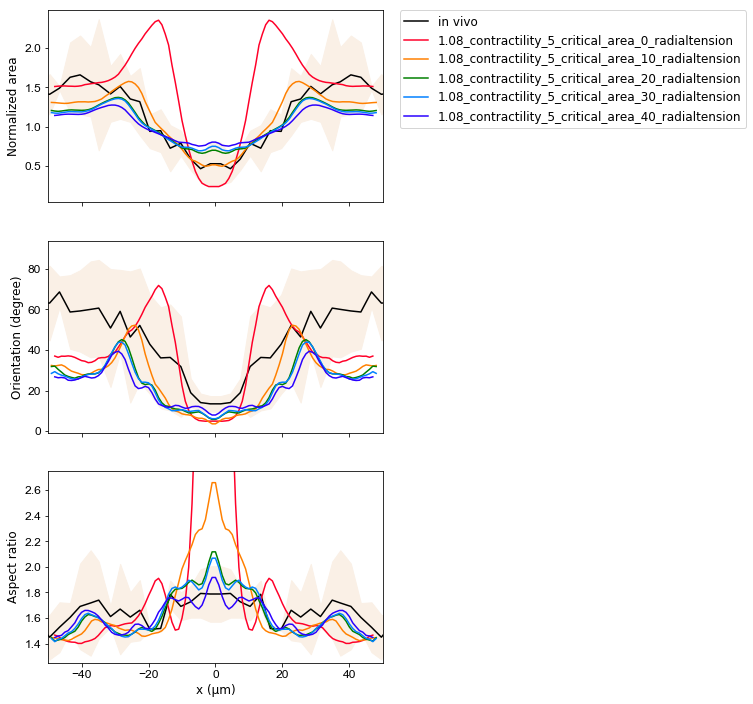

In [54]:
fig, (ax_area, ax_orient, ax_ar) = plt.subplots(3, 1, sharex=True, sharey=False)
#matplotlib.rcdefaults()

# Add mean in vivo curve  
in_vivo_plot (means, stds, 'area', normalized=True, ax=ax_area)
in_vivo_plot (means, stds, 'orient', normalized=False, ax=ax_orient)
in_vivo_plot (means, stds, 'ar', normalized=False, ax=ax_ar)


jet = plt.get_cmap('jet')
cNorm  = colors.Normalize(vmin=0, vmax=len(rollings_silico.items()))
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)

color_d={}
i=0

color_list = [(1.0, 0.0, 0.16, 1.0),
            (1.0, 0.5, 0.0, 1.0), 
            (0.0, 0.5, 0.0, 1.0), 
            (0.0, 0.5, 1.0, 1.0), 
            (0.16304347826086973, 0.0, 1.0, 1.0), 
            (0.51, 0.0, 0.51, 1.0)]

for name, rol in rollings_silico.items():
    dir_name_vivo = name.split('_invagination')[0]
    color_d[dir_name_vivo] = color_list[i]
    i=i+1
    
    
label_dict = {}
for repo in chosen_repository:
    label_dict[repo] = ("contractility : " + str(round((float(repo.split('_')[0])-1)*100,0)) +
                            '%   Force AB : ' + str(repo.split('_')[5]))
    


# Add in silico results
in_silico_plot(rollings_silico, 'area', normalized=True, ax=ax_area)
in_silico_plot(rollings_silico, 'orient', normalized=False, ax=ax_orient)
in_silico_plot(rollings_silico, 'ar', normalized=False, ax=ax_ar)


    
ax_area.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., prop={'size': 12, 'family':'sans-serif'})

ax_area.set_ylabel('Normalized area', size=12, family='sans-serif')
for tick in ax_area.xaxis.get_ticklabels():
    tick.set_fontsize(12)
    tick.set_fontname('Arial')
for tick in ax_area.yaxis.get_ticklabels():
    tick.set_fontsize(12)
    tick.set_fontname('Arial')
    
ax_orient.set_ylabel('Orientation (degree)', size=12, family='sans-serif')
for tick in ax_orient.xaxis.get_ticklabels():
    tick.set_fontsize(12)
    tick.set_fontname('Arial')
for tick in ax_orient.yaxis.get_ticklabels():
    tick.set_fontsize(12)
    tick.set_fontname('Arial')
    
ax_ar.set_xlabel('x (µm)', size=12, family='sans-serif')
ax_ar.set_ylabel('Aspect ratio', size=12, family='sans-serif')
ax_ar.set_ylim(1.25, 2.75)
ax_ar.set_xlim(-50, 50)
for tick in ax_ar.xaxis.get_ticklabels():
    tick.set_fontsize(12)
    tick.set_fontname('Arial')
for tick in ax_ar.yaxis.get_ticklabels():
    tick.set_fontsize(12)
    tick.set_fontname('Arial')

fig.set_size_inches(6, 12)
fig.savefig('../morphoemtry_principal_result.svg', dpi = 150)

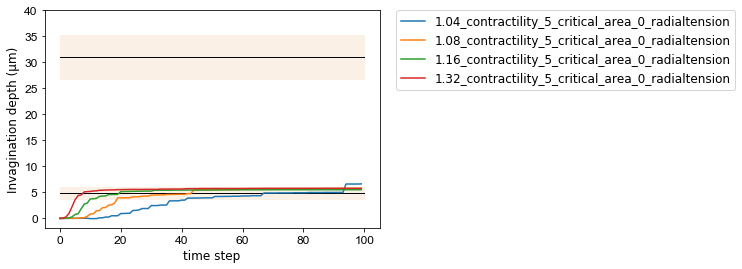

In [78]:
from invagination.toolbox import define_depth 
fig, ax = plt.subplots(1, 1, sharex=True, sharey=False)

color_list = [(1.0, 0.0, 0.16, 1.0),
            (1.0, 0.5, 0.0, 1.0), 
            (0.0, 0.5, 0.0, 1.0), 
            (0.0, 0.5, 1.0, 1.0), 
            (0.16304347826086973, 0.0, 1.0, 1.0), 
            (0.51, 0.0, 0.51, 1.0)]
i=0
for name, rol in rollings_silico.items():
    dir_name_vivo = name.split('_invagination')[0]
    #color_d[dir_name_vivo] = color_list[i]
    i=i+1
    


    depth0 = define_depth(os.path.join(sim_data_dirs, dir_name_vivo), 0, ['z', 'x'])
    res_d = []
    for t in range (0,100):
        res_d.append(depth0 - define_depth(os.path.join(sim_data_dirs, dir_name_vivo), t, ['z', 'x']))
    ax.plot ( res_d, label=dir_name_vivo)
#ax.axhline(4.9, color="black")

ax.fill_between(np.linspace(0,100), 4.9-1.1,  
                        4.9+1.1,
                        color="linen") 
ax.fill_between(np.linspace(0,100), 4.9-0.01,  
                        4.9+0.01,
                        color="black") 

ax.fill_between(np.linspace(0,100), 31-4.2,  
                        31+4.2,
                        color="linen") 
ax.fill_between(np.linspace(0,100), 31-0.01,  
                        31+0.01,
                        color="black") 
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., prop={'size': 12, 'family':'sans-serif'})

ax.set_xlabel('time step', size=12, family='sans-serif')
ax.set_ylabel('Invagination depth (µm)', size=12, family='sans-serif')
for tick in ax.xaxis.get_ticklabels():
    tick.set_fontsize(12)
    tick.set_fontname('Arial')
for tick in ax.yaxis.get_ticklabels():
    tick.set_fontsize(12)
    tick.set_fontname('Arial')
ax.set_ylim(ymax=40)
fig.savefig('../depth_to_time.svg', dpi = 150)

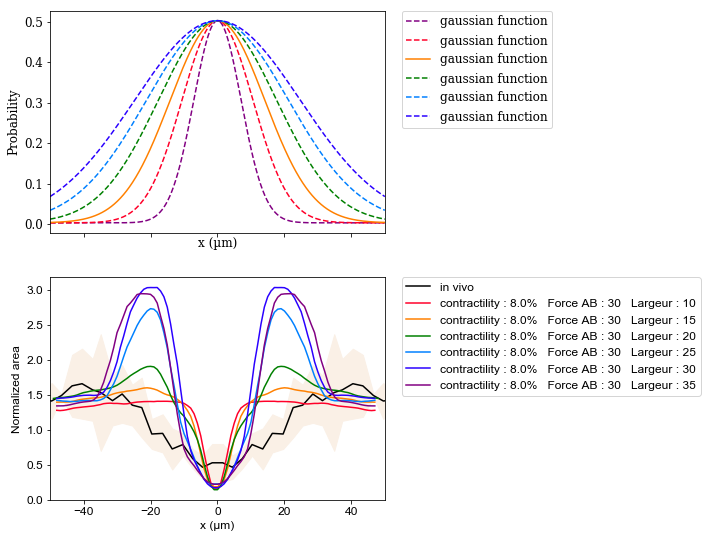

In [15]:
def in_vivo_plot (means, stds, column, normalized=False, ax=None):
    if ax is None : 
        fig, ax = plt.subplots()
    else:
        fig = ax.get_figure()
        
    collected_means = pd.concat(means, ignore_index=True)
    collected_stds = pd.concat(stds, ignore_index=True)
    
    mean = collected_means.groupby('bin').mean()
    std = collected_means.groupby('bin').std().dropna()

    
    val=np.concatenate((-mean['abs_x'][0:len(std)][::-1], mean['abs_x'][0:len(std)]))
    
    
    val2 = np.concatenate(((mean[column] - std[column])[0:len(std)][::-1], 
                           (mean[column] - std[column])[0:len(std)]))
    val3 = np.concatenate(((mean[column] + std[column])[0:len(std)][::-1], 
                           (mean[column] + std[column])[0:len(std)]))

    ax.fill_between(val, val2,  
                        val3,
                        color="linen") 
    ax.plot(val, np.concatenate((mean[column][0:len(std)][::-1], mean[column][0:len(std)])), label='in vivo',color= 'black')
    



import itertools
import matplotlib.pyplot as plt 
import matplotlib.colors as colors
import matplotlib.cm as cmx
import numpy as np


fig, (ax_init, ax) = plt.subplots(2, 1, sharex=True, sharey=False)


color_d = {'15':(1.0, 0.0, 0.16, 1.0),
           '20': (1.0, 0.5, 0.0, 1.0), 
           '25': (0.0, 0.5, 0.0, 1.0), 
           '30': (0.0, 0.5, 1.0, 1.0), 
           '35': (0.16304347826086973, 0.0, 1.0, 1.0), 
           '10': (0.51, 0.0, 0.51, 1.0)}

color_list = [(1.0, 0.0, 0.16, 1.0),
            (1.0, 0.5, 0.0, 1.0), 
            (0.0, 0.5, 0.0, 1.0), 
            (0.0, 0.5, 1.0, 1.0), 
            (0.16304347826086973, 0.0, 1.0, 1.0), 
            (0.51, 0.0, 0.51, 1.0)]

n=2
"""x = np.linspace(-50,50, 1000)
ax_init.plot (x, 1+(1-1.08) + ((1+np.exp(-0.19*15))/(1+np.exp(0.19*(abs(x)-15)))),'--', color = color_d['15'], label = 'gaussian function')
ax_init.plot (x, 1+(1-1.08) + ((1+np.exp(-0.19*20))/(1+np.exp(0.19*(abs(x)-20)))), '--',color = color_d['20'], label = 'gaussian function')
ax_init.plot (x, 1+(1-1.08) + ((1+np.exp(-0.19*25))/(1+np.exp(0.19*(abs(x)-25)))), '--', color = color_d['25'], label = 'gaussian function')
ax_init.plot (x, 1+(1-1.08) + ((1+np.exp(-0.19*30))/(1+np.exp(0.19*(abs(x)-30)))),'--', color = color_d['30'], label = 'gaussian function')
ax_init.plot (x, 1+(1-1.08) + ((1+np.exp(-0.19*35))/(1+np.exp(0.19*(abs(x)-35)))),'--', color = color_d['35'], label = 'gaussian function')
ax_init.plot (x, 1+(1-1.08) + ((1+np.exp(-0.19*40))/(1+np.exp(0.19*(abs(x)-10)))),'--', color = color_d['10'], label = 'gaussian function')
"""
ax_init.plot (x, 0.003 + 0.5 * np.exp(-abs(x)**n / 10**n),'--', color = color_d['10'], label = 'gaussian function')
ax_init.plot (x, 0.003 + 0.5 * np.exp(-abs(x)**n / 15**n), '--',color = color_d['15'], label = 'gaussian function')
ax_init.plot (x, 0.003 + 0.5 * np.exp(-abs(x)**n / 20**n), color = color_d['20'], label = 'gaussian function')
ax_init.plot (x, 0.003 + 0.5 * np.exp(-abs(x)**n / 25**n),'--', color = color_d['25'], label = 'gaussian function')
ax_init.plot (x, 0.003 + 0.5 * np.exp(-abs(x)**n / 30**n),'--', color = color_d['30'], label = 'gaussian function')
ax_init.plot (x, 0.003 + 0.5 * np.exp(-abs(x)**n / 35**n),'--', color = color_d['35'], label = 'gaussian function')

ax_init.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., prop={'size': 12, 'family':'serif'})
ax_init.set_xlabel('x (µm)', size=12, family='serif')
ax_init.set_ylabel('Probability', size=12, family='serif')
for tick in ax_init.xaxis.get_ticklabels():
    tick.set_fontsize(12)
    tick.set_fontname('serif')
for tick in ax_init.yaxis.get_ticklabels():
    tick.set_fontsize(12)
    tick.set_fontname('serif')

# GRAPHE 2---------------------------------------------------------   

dirname =Path('/home/admin-suz/Documents/SimulationsReview/2018-07-18')

list_dir = os.listdir(dirname)
list_dir = sorted(list_dir)
list_dir = list_dir[:-2]


decallage_in_vivo = {'20161108' : 15, '20170519':-12, '20170531':35}
in_vivo_plot (means, stds, 'area', normalized=True, ax=ax)

    
i=0
for name, rol in rollings_silico.items():
    dir_name_vivo = name.split('_invagination')[0]
    color_d[dir_name_vivo] = color_list[i]
    i=i+1
    
label_dict = {}
for repo in chosen_repository:
    label_dict[repo] = ("contractility : " + str(round((float(repo.split('_')[0])-1)*100,0)) +
                            '%   Force AB : ' + str(repo.split('_')[5])+
                            '   Largeur : ' + str(repo.split('_')[7]))
    


# Add in silico results
in_silico_plot(rollings_silico, 'area', normalized=True, ax=ax)
    

    
    
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., prop={'size': 12, 'family':'Arial'})

ax.set_xlabel('x (µm)', size=12, family='sans-serif', fontname='Arial')
ax.set_ylabel('Normalized area', size=12, family='sans-serif', fontname = 'Arial')
for tick in ax.xaxis.get_ticklabels():
    tick.set_fontsize(12)
    tick.set_fontname('Arial')
for tick in ax.yaxis.get_ticklabels():
    tick.set_fontsize(12)
    tick.set_fontname('Arial')

ax.set_xlim(-50,50)
fig.set_size_inches(6, 9)
fig.savefig('../test_largeur_gaussienne_result.svg', dpi = 150)

